In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import glob
import os.path
import numpy as np
import sys
import codecs
import json
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [0]:
train_folder = "./drive/My Drive/datasets/train-articles" # check that the path to the datasets folder is correct, 
dev_folder = "./drive/My Drive/datasets/dev-articles"     # if not adjust these variables accordingly
train_labels_file = "./drive/My Drive/datasets/train-task2-TC.labels"
dev_template_labels_file = "./drive/My Drive/datasets/dev-task-TC-template.out"
task_TC_output_file = "TFIDF_LR.txt"

def read_articles_from_file_list(folder_name, file_pattern="*.txt"):
    """
    Read articles from files matching patterns <file_pattern> from  
    the directory <folder_name>. 
    The content of the article is saved in the dictionary whose key
    is the id of the article (extracted from the file name).
    Each element of <sentence_list> is one line of the article.
    """
    file_list = glob.glob(os.path.join(folder_name, file_pattern))
    articles = {}
    article_id_list, sentence_id_list, sentence_list = ([], [], [])
    for filename in sorted(file_list):
        article_id = os.path.basename(filename).split(".")[0][7:]
        with codecs.open(filename, "r", encoding="utf8") as f:
            articles[article_id] = f.read()
    return articles


def read_predictions_from_file(filename):
    """
    Reader for the gold file and the template output file. 
    Return values are four arrays with article ids, labels 
    (or ? in the case of a template file), begin of a fragment, 
    end of a fragment. 
    """
    articles_id, span_starts, span_ends, gold_labels = ([], [], [], [])
    with open(filename, "r") as f:
        for row in f.readlines():
            article_id, gold_label, span_start, span_end = row.rstrip().split("\t")
            articles_id.append(article_id)
            gold_labels.append(gold_label)
            span_starts.append(span_start)
            span_ends.append(span_end)
    return articles_id, span_starts, span_ends, gold_labels

def compute_features_b(articles, span_starts, span_ends):
    # only one feature, the length of the span
    return np.array([ int(sp_ends)-int(sp_starts) for sp_starts, sp_ends in zip(span_starts, span_ends) ]).reshape(-1, 1)

def clean(text):
    text=text.lower()
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text=re.sub('[“"”]',' " ',text)
    retain='[^abcdefghijklmnopqrstuvwxyz!#?". ]'
    text=re.sub('[()–-]',' ',text)
    text=re.sub(retain,'',text)
    text=re.sub('[.]',' . ',text)
    text=text.replace('?',' ? ')
    text=text.replace('#',' # ')
    text=text.replace('!',' ! ')
    return ' '.join(text.split())

# loading articles' content from *.txt files in the train folder
articles = read_articles_from_file_list(train_folder)
dev_articles = read_articles_from_file_list(dev_folder)

def read_span(id,span,dev=False):
    if dev:
        return dev_articles[id][span[0]:span[1]]
    else:
        return articles[id][span[0]:span[1]]

In [5]:
# loading gold labels, articles ids and sentence ids from files *.task-TC.labels in the train labels folder 
ref_articles_id, ref_span_starts, ref_span_ends, train_gold_labels = read_predictions_from_file(train_labels_file)
print("Loaded %d annotations from %d articles" % (len(ref_span_starts), len(set(ref_articles_id))))

# reading data from the development set
dev_article_ids, dev_span_starts, dev_span_ends, dev_labels = read_predictions_from_file(dev_template_labels_file)

Loaded 6129 annotations from 357 articles


In [0]:
in_data=[(id, [int(sps),int(spe)])for id, sps, spe in zip(ref_articles_id, ref_span_starts, ref_span_ends)]
df=pd.DataFrame(in_data,columns=['ID','Span'])
df['Sentence']=[read_span(id,span) for id,span in zip(df['ID'].tolist(),df['Span'].tolist())]
df['Sentence']=df['Sentence'].apply(lambda x : clean(x))
df['Span']=df['Span'].apply(lambda x : x[1]-x[0])
df['Target']=train_gold_labels
df=df.drop_duplicates()

In [0]:
dev_data=[(id, [int(sps),int(spe)])for id, sps, spe in zip(dev_article_ids, dev_span_starts, dev_span_ends)]
df_dev=pd.DataFrame(dev_data,columns=['ID','Span'])
df_dev['Sentence']=[read_span(id,span,dev=True) for id,span in zip(df_dev['ID'].tolist(),df_dev['Span'].tolist())]
df_dev['Sentence']=df_dev['Sentence'].apply(lambda x : clean(x))
df_dev['Span']=df_dev['Span'].apply(lambda x : x[1]-x[0])

In [0]:
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer

In [0]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,ngram_range=(2,6),stop_words='english',analyzer='char')
tfidf_w = TfidfVectorizer(sublinear_tf=True, min_df=6,ngram_range=(1,3),stop_words='english',analyzer='word')
features = np.append(tfidf.fit_transform(df.Sentence).toarray(),df['Span'].values.reshape(-1,1),axis=1).astype('float16')
features = np.append(tfidf_w.fit_transform(df.Sentence).toarray(),features,axis=1).astype('float16')
X_train, X_test, Y_train, Y_test = train_test_split(features,df['Target'],stratify=df['Target'],test_size=0.2,random_state=1234)

In [0]:
model_lr=LogisticRegression(penalty='l2', class_weight='balanced', solver="liblinear", max_iter=500)
model_lr.fit(X_train, Y_train)
pred_lr=model_lr.predict(X_test)

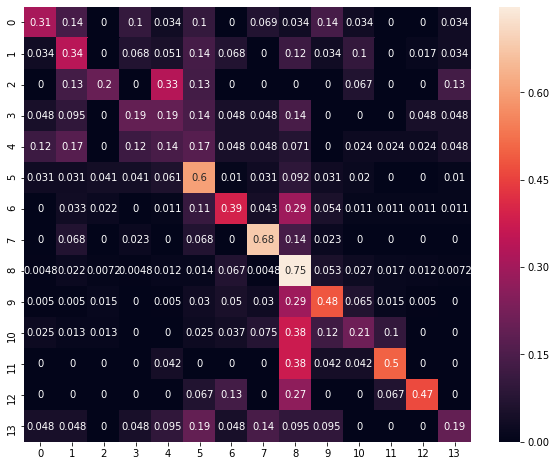

In [25]:
cm=confusion_matrix(Y_test,pred_lr)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (10,8))
sns.heatmap(cm,annot=True)

In [26]:
print(classification_report(Y_test,pred_lr))

                                    precision    recall  f1-score   support

               Appeal_to_Authority       0.35      0.31      0.33        29
          Appeal_to_fear-prejudice       0.36      0.34      0.35        59
    Bandwagon,Reductio_ad_hitlerum       0.19      0.20      0.19        15
           Black-and-White_Fallacy       0.17      0.19      0.18        21
         Causal_Oversimplification       0.17      0.14      0.16        42
                             Doubt       0.52      0.60      0.56        98
         Exaggeration,Minimisation       0.41      0.39      0.40        92
                       Flag-Waving       0.51      0.68      0.58        44
                   Loaded_Language       0.66      0.75      0.70       415
             Name_Calling,Labeling       0.66      0.48      0.56       201
                        Repetition       0.31      0.21      0.25        80
                           Slogans       0.36      0.50      0.42        24
       Thou

In [27]:
DF=pd.concat([df,df_dev])
features = tfidf.fit_transform(DF.Sentence).toarray().astype('float16')
features_w = tfidf.fit_transform(DF.Sentence).toarray().astype('float16')
features = np.append(features,DF['Span'].values.reshape(-1,1),axis=1)
features= np.append(features,features_w,axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [0]:
Train_X, Train_Y = features[:5780], DF[:5780]['Target']
Test=features[5780:]

In [0]:
model_lr=LogisticRegression(penalty='l2', class_weight='balanced', solver="liblinear", max_iter=500)
model_lr.fit(Train_X, Train_Y)
pred_lr=model_lr.predict(Test)

In [30]:
##### writing predictions to file
with open(task_TC_output_file, "w") as fout:
    for article_id, prediction, span_start, span_end in zip(dev_article_ids, pred_lr, dev_span_starts, dev_span_ends):
        fout.write("%s\t%s\t%s\t%s\n" % (article_id, prediction, span_start, span_end))
print("Predictions written to file " + task_TC_output_file)

Predictions written to file TFIDF_LR.txt


In [0]:
from google.colab import files
files.download('./TFIDF_LR.txt')